
# Simple linear regression example

The model equation is y = ax + b with a, b being the model parameters, while the
likelihood model is based on a normal zero-mean additive model error distribution with
the standard deviation to infer. The problem is solved via maximum likelihood estimation
as well as via sampling using emcee.


First, let's import the required functions and classes for this example.



In [1]:
# third party imports
import numpy as np
import matplotlib.pyplot as plt

# local imports (problem definition)
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal, Uniform, SpikeAndSlab, Bernoulli, RegularisedHorseShoe, HalfCauchy, InvGamma, HorseShoe
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel

# local imports (problem solving)
from probeye.inference.scipy.solver import MaxLikelihoodSolver
from probeye.inference.emcee.solver import EmceeSolver
from probeye.inference.dynesty.solver import DynestySolver

# local imports (inference data post-processing)
from probeye.postprocessing.sampling_plots import create_pair_plot
from probeye.postprocessing.sampling_plots import create_posterior_plot
from probeye.postprocessing.sampling_plots import create_trace_plot

We start by generating a synthetic data set from a known linear model to which we will
add some noise. Afterwards, we will pretend to have forgotten the parameters of this
ground-truth model and will instead try to recover them just from the data. The slope
(a) and intercept (b) of the ground truth model are set to be:



In [2]:
# ground truth
a_true = 8
b_true = 10

Now, let's generate a few data points that we contaminate with a Gaussian error:



In [3]:
# settings for data generation
n_tests = 50
seed = 1
mean_noise = 0.0
std_noise = 1

# generate the data
np.random.seed(seed)
x_test = np.linspace(-4.0, 4.0, n_tests)
y_true = a_true * x_test + b_true #a_true * x_test**2 #+ b_true * x_test + c_true #a_true * x_test**2 + 
y_test = y_true + np.random.normal(loc=mean_noise, scale=std_noise, size=n_tests)

Let's take a look at the data that we just generated:



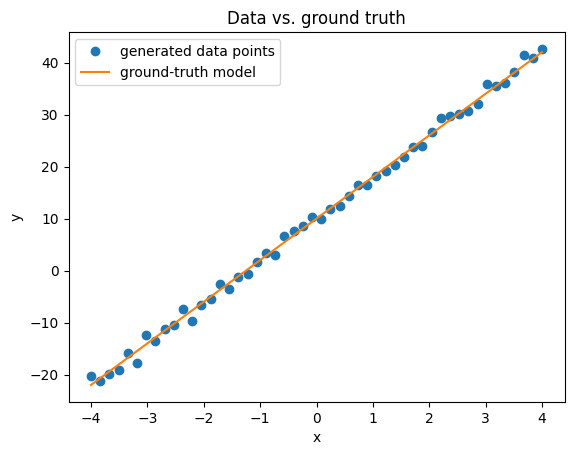

In [4]:
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
#plt.plot(x_test, - 2*x_test , label="ground-truth model") #1*np.exp(x_test)
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Until this point, we didn't use probeye at all, since we just generated some data. In
a normal use case, we wouldn't have to generate our data of course. Instead, it would
be provided to us, for example as the result of some test series. As the first step in
any calibration problem, one needs to have a parameterized model (in probeye such a
model is called 'forward model') of which one assumes that it is able to describe the
data at hand. In this case, if we took a look at the blue data points in the plot
above without knowing the orange line, we might expect a simple linear model. It is
now our job to describe this model within the probeye-framework. This is done by
defining our own specific model class:



In [29]:
import json
with open('parameters.json', 'r') as f: 
    json_object = json.loads(f.read()) 

#for parameter in json_object.get('parameters'):
#    print(type(parameter))

In [14]:
def log_likelihood(theta, _x_test, _y_test, _sigma):
    y_model = theta[0] * _x_test + theta[1] 
    return -0.5 * np.sum((_y_test - y_model) ** 2 / _sigma**2 + np.log(_sigma**2))

from scipy.stats import invgamma, halfcauchy, norm, bernoulli

def log_prior(theta):
    _lp = 0
    i = 0
    for parameter in json_object.get('parameters'):
        if parameter['prior'][0] == 'Normal':
            _lp += norm.logpdf(theta[i], loc = parameter['prior'][1]["loc"], scale = parameter['prior'][1]["scale"])
            i += 1   
    return _lp
            

def log_probability(theta, _x_test, _y_test, _std_noise):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, _x_test, _y_test, _std_noise)



import emcee
nwalkers = 20
ndim = 2

start_parameters = np.zeros((nwalkers, ndim))
counter = 0

for parameter in json_object.get('parameters'):
    if parameter['prior'][0] == 'Bernoulli':
        start_parameters[0] = bernoulli.rvs(p = parameter['prior'][1]["p"], size=nwalkers)
    elif parameter['prior'][0] == 'Spike-Slab':
    


pos = np.random.normal(loc=0.0, scale=1.0, size=(nwalkers, ndim))
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_test, y_test, std_noise)
)
sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:13<00:00, 360.22it/s]


State([[ 8.00935991 10.09655514]
 [ 8.04996625 10.09841138]
 [ 8.01484602  9.96478756]
 [ 8.05707756  9.81666287]
 [ 8.11161324 10.01460112]
 [ 8.01607215 10.06905334]
 [ 8.02786978 10.06723614]
 [ 8.07549821 10.05426485]
 [ 8.19594048 10.04045931]
 [ 8.02276115 10.19250795]
 [ 8.08125955 10.21550453]
 [ 8.1266542   9.99192898]
 [ 8.07770268  9.97997778]
 [ 8.02280757  9.98920047]
 [ 8.09766263  9.84943846]
 [ 7.95427882  9.94574236]
 [ 8.03794233  9.98391647]
 [ 7.90183949  9.94293608]
 [ 8.09086492  9.83273326]
 [ 8.06605504 10.03537805]], log_prob=[-28.43964364 -28.22177867 -27.99498526 -28.4329761  -28.39397835
 -28.21758984 -28.11696248 -28.08134548 -30.89524457 -29.14196119
 -29.44136376 -28.64715347 -27.92988396 -27.93210725 -28.51315475
 -29.11177926 -27.84570501 -30.89147255 -28.53914735 -27.95808689], blobs=None, random_state=('MT19937', array([3480050595, 2256324502, 2485079415, 3891499331, 3646094766,
       1289429520, 2939152963, 1788893990, 3956587655,  589006295,
      

As the next step, we need to add our experimental data the forward model and the
likelihood model. Note that the order is important and should not be changed.



In [33]:
nwalkers = 20
ndim = 2
from scipy.stats import invgamma, halfcauchy, norm, bernoulli
start_parameters = np.zeros((nwalkers, ndim))
counter = 0

for index, parameter in enumerate(json_object.get('parameters')):
    if parameter['prior'][0] == 'Bernoulli':
        start_parameters[:, index] = bernoulli.rvs(p = parameter['prior'][1]["p"], size=nwalkers)
    elif parameter['prior'][0] == 'Spike-Slab':
        for hyperparameter in parameter['hyperparameters']:
            for ind, param in enumerate(json_object.get('parameters')):
                if hyperparameter == param['name']:
                    lmbda = start_parameters[:, ind]
                    print(lmbda)
        start_parameters[:, index] = lmbda*norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"], size=nwalkers)        
print(start_parameters)

[1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
[[ 1.          2.54633364]
 [ 0.          0.        ]
 [ 1.          6.48364914]
 [ 0.         -0.        ]
 [ 1.         -1.00669683]
 [ 1.          1.53086069]
 [ 0.         -0.        ]
 [ 1.         -1.56726496]
 [ 1.          2.73600531]
 [ 1.         -1.41363993]
 [ 0.         -0.        ]
 [ 0.          0.        ]
 [ 1.         -1.69797116]
 [ 1.         -2.92612393]
 [ 1.         -6.2629526 ]
 [ 1.          4.05528987]
 [ 1.         -8.90845053]
 [ 1.         -6.79733442]
 [ 0.         -0.        ]
 [ 1.          4.91582234]]


(6000, 2)


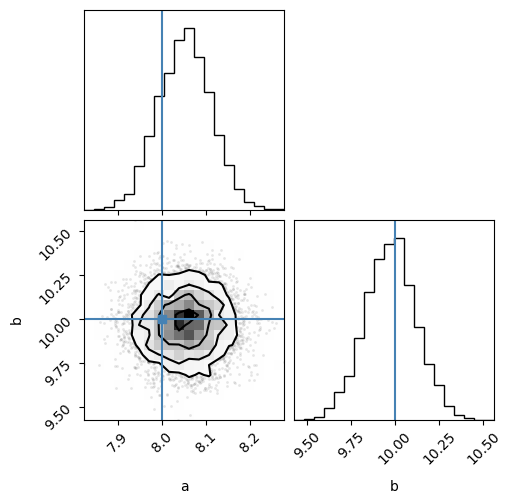

In [15]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)
import corner
labels = ["a", "b"]
fig = corner.corner(
    flat_samples, labels=labels, truths=[8, 10]
)

Now, our problem definition is complete, and we can take a look at its summary:



After the problem definition comes the problem solution. There are different solver
one can use, but we will just demonstrate how to use two of them: the scipy-solver,
which merely provides a point estimate based on a maximum likelihood optimization, and
the emcee solver, which is a MCMC-sampling solver. Let's begin with the scipy-solver:



All solver have in common that they are first initialized, and then execute a
run-method, which returns its result data in the format of an arviz inference-data
object (except for the scipy-solver). Let's now take a look at the emcee-solver.



In [ ]:
# this is for using the emcee-solver (MCMC sampling)
emcee_solver = EmceeSolver(problem, show_progress=True)
inference_data = emcee_solver.run(n_steps=2000, n_initial_steps=1, n_walkers=20)
posterior = emcee_solver.raw_results.get_chain()

Finally, we want to plot the results we obtained. To that end, probeye provides some
post-processing routines, which are mostly based on the arviz-plotting routines.



In [ ]:
# this is optional, since in most cases we don't know the ground truth
true_values = {"a": a_true, "b": b_true, "lmbda_a": 1, "lmbda_b": 1}

#true_values = {"a": 0, "b": b_true, "lmbda_a": 0, "sigma": std_noise}

# this is an overview plot that allows to visualize correlations
pair_plot_array = create_pair_plot(
    inference_data,
    emcee_solver.problem,
    true_values=true_values,
    focus_on_posterior=True,
    show_legends=True,
    title="Sampling results from emcee-Solver (pair plot)",
)

In [ ]:
# this is a posterior plot, without including priors
post_plot_array = create_posterior_plot(
    inference_data,
    emcee_solver.problem,
    true_values=true_values,
    title="Sampling results from emcee-Solver (posterior plot)",
)

In [ ]:
# trace plots are used to check for "healthy" sampling
trace_plot_array = create_trace_plot(
    inference_data,
    emcee_solver.problem,
    title="Sampling results from emcee-Solver (trace plot)",
)

In [ ]:
import numpy as np
from scipy.stats import invgamma
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 3, 100)

r = invgamma.rvs(3, size=1000)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)

rv = invgamma(3, scale=0.5)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

plt.show()

In [ ]:
import numpy as np
from scipy.stats import invgamma, halfcauchy, norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(halfcauchy.ppf(0.01),
                halfcauchy.ppf(0.99), 100)
ax.plot(x, halfcauchy.pdf(x),
       'r-', lw=2, alpha=0.6, label='halfcauchy pdf')
ax.plot(x, norm.pdf(x, scale=0.1),
       'b-', lw=2, alpha=0.6, label='halfcauchy pdf')
plt.show()

In [ ]:
import numpy as np
from scipy.stats import invgamma, halfcauchy, norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=2, alpha=0.6, label='halfcauchy pdf')
ax.plot(x, norm.pdf(x, scale=0.1),
       'b-', lw=2, alpha=0.6, label='halfcauchy pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
beta2 = norm.rvs(loc = 0, scale= 0.1, size=200)
ax.hist(beta2, density=True, bins=200, histtype='stepfilled')
ax.legend(loc='best', frameon=False)

plt.show()


In [ ]:
import numpy as np
from scipy.stats import invgamma, halfcauchy, norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

lmbda = halfcauchy.rvs(loc = 0, scale= 1, size=200)
tau = halfcauchy.rvs(loc = 0, scale= 1, size=15)
beta = norm.rvs(loc = 0, scale= np.square(lmbda*0.1), size=200)
#for i in range(15):
#    ax.hist(beta, density=True, bins=50, histtype='stepfilled')
#    #ax.plot(x, norm.pdf(x, loc = 0, scale= np.square(lmbda[i]*tau[i])), 'k-', lw=2, label='frozen pdf')


print(beta.shape)
ax.hist(beta, density=True, bins=200, histtype='stepfilled')
ax.legend(loc='best', frameon=False)

plt.show()


In [ ]:
halfcauchy.logpdf(-1)


In [ ]:
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
plt.plot(x_test, -0.9*np.exp(-x_test) -10 , label="ground-truth model")
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()